## Daisy's Test/Train Code


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# Set path to local data directory
folder_path = ""

# Define file paths
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


In [3]:
# Apply feature engineering function to the combined DataFrame (includes both first + last 30 min)
def compute_orderbook_features(df):
    """
    Compute engineered order book features from raw order book snapshots.
    """
    df = df.copy()

    # Mid price and Weighted Average Price
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['wap'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (
        df['bid_size1'] + df['ask_size1']
    )

    # Spread and relative spread
    df['bid_ask_spread'] = df['ask_price1'] - df['bid_price1']
    df['spread_pct'] = df['bid_ask_spread'] / df['mid_price']

    # Spread variation over time within the same time_id
    df['spread_variation'] = df.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )

    # Order book imbalance and depth ratio
    df['imbalance'] = (df['bid_size1'] - df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['depth_ratio'] = df['bid_size1'] / df['ask_size1'].replace(0, np.nan)

    # Return only the engineered features
    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'spread_variation', 'bid_ask_spread'
    ]
    return df[keep_cols]

# Apply feature engineering to the combined order book data
feature_engineered_df = compute_orderbook_features(combined_df)

# Preview result
feature_engineered_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread
0,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,NaN,0.26
1,8382,6,1800.0,740.160000,0.000351,0.000000,1.000000,0.000000,0.26
2,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
3,8382,6,1801.0,740.280769,0.000324,0.923077,25.000000,0.000016,0.24
4,8382,6,1802.0,740.290769,0.000405,0.538462,3.333333,0.000033,0.30


In [4]:
time_ref_path = os.path.join(folder_path, "time_id_reference.csv")
time_ref_df = pd.read_csv(time_ref_path)
time_ref_df.head()

,date,time,time_id
0,2021-01-05,11:00:00,12
1,2021-01-05,12:00:00,13
2,2021-01-05,13:00:00,14
3,2021-01-05,14:00:00,15
4,2021-01-05,15:00:00,16


In [5]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])
time_ref_df.head()

,date,time,time_id,datetime
0,2021-01-05,11:00:00,12,2021-01-05 11:00:00
1,2021-01-05,12:00:00,13,2021-01-05 12:00:00
2,2021-01-05,13:00:00,14,2021-01-05 13:00:00
3,2021-01-05,14:00:00,15,2021-01-05 14:00:00
4,2021-01-05,15:00:00,16,2021-01-05 15:00:00


In [6]:
# Re-do the merge and keep only the new datetime column
feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.head()
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime
35557446,104919,1199,3595.0,362.731439,0.000028,-0.712230,0.168067,0.000012,0.01,2021-10-07 16:00:00
35557447,104919,1199,3596.0,362.696000,0.000055,0.600000,4.000000,0.000012,0.02,2021-10-07 16:00:00
35557448,104919,1199,3597.0,362.691818,0.000028,-0.636364,0.222222,0.000012,0.01,2021-10-07 16:00:00
35557449,104919,1199,3598.0,362.721667,0.000028,-0.666667,0.200000,0.000012,0.01,2021-10-07 16:00:00
35557450,104919,1199,3599.0,362.804000,0.000028,-0.200000,0.666667,0.000012,0.01,2021-10-07 16:00:00


In [7]:
# Sort just in case
feature_engineered_df = feature_engineered_df.sort_values(by="time_id")

# Unique time_ids
unique_ids = sorted(feature_engineered_df["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)

# Train on earliest 80%, test on latest 20%
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(train_ids)]
test_df_timeid = feature_engineered_df[feature_engineered_df["time_id"].isin(test_ids)]

print("TimeID Split:")
print("Train shape:", train_df_timeid.shape)
print("Test shape:", test_df_timeid.shape)

TimeID Split:
Train shape: (28513833, 10)
Test shape: (7043618, 10)


In [8]:
qqq_df = feature_engineered_df[feature_engineered_df["stock_id"] == 104919].copy()
qqq_df["date_only"] = qqq_df["datetime"].dt.date

qqq_df.head()

,stock_id,time_id,seconds_in_bucket,wap,spread_pct,imbalance,depth_ratio,spread_variation,bid_ask_spread,datetime,date_only
31393488,104919,6,2992.0,312.299875,0.000032,0.975000,79.000000,0.000017,0.01,NaT,NaT
31393489,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393490,104919,6,2993.0,312.262896,0.000064,-0.710446,0.169286,0.000017,0.02,NaT,NaT
31393491,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT
31393492,104919,6,2994.0,312.280598,0.000064,-0.940178,0.030833,0.000017,0.02,NaT,NaT


In [9]:
#  Compute log returns (per time_id)
qqq_df["log_return"] = qqq_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))

# Compute realized volatility per time_id
rv_df = qqq_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into qqq_df
qqq_df = pd.merge(qqq_df, rv_df, on="time_id", how="left")

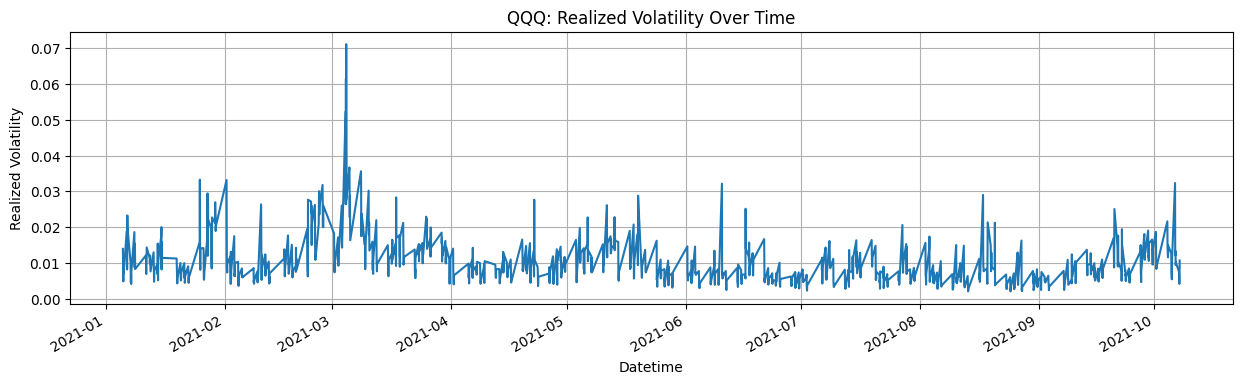

In [10]:
# Plot volatility over time
qqq_df.groupby("datetime")["realized_volatility"].mean().plot(
    figsize=(15, 4), title="QQQ: Realized Volatility Over Time"
)
plt.xlabel("Datetime")
plt.ylabel("Realized Volatility")
plt.grid(True)
plt.show()

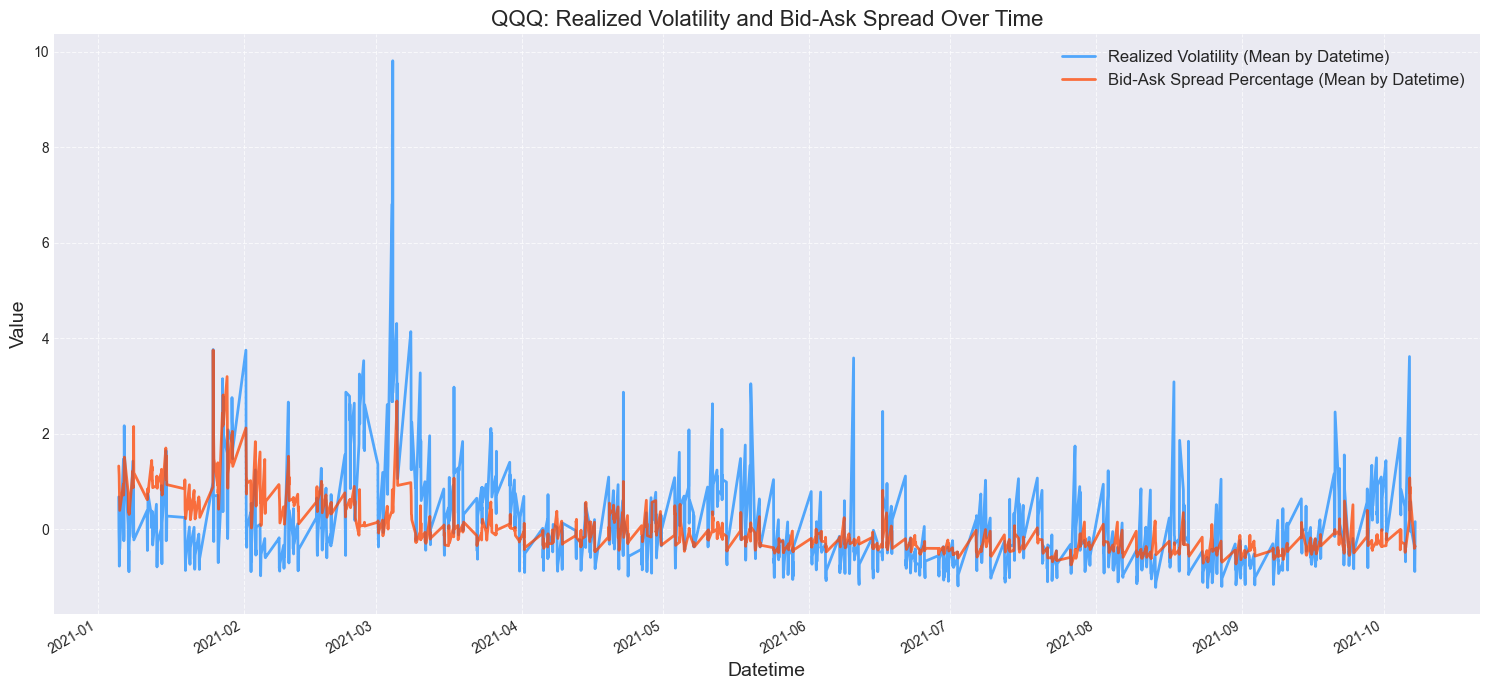

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
qqq_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(qqq_df[['spread_pct', 'realized_volatility']])


realized_vol_by_datetime = qqq_df.groupby("datetime")["realized_volatility_scaled"].mean()
bid_ask_spread_by_datetime = qqq_df.groupby("datetime")["spread_pct_scaled"].mean()

# Plotting
plt.figure(figsize=(15, 7)) # Adjusted figsize for better visibility of two lines
plt.style.use('seaborn-v0_8-darkgrid')

realized_vol_by_datetime.plot(
    label="Realized Volatility (Mean by Datetime)",
    color='dodgerblue',
    linewidth=2,
    alpha=0.75
)
bid_ask_spread_by_datetime.plot(
    label="Bid-Ask Spread Percentage (Mean by Datetime)",
    color='orangered',
    linewidth=2,
    alpha=0.75
)

plt.title("QQQ: Realized Volatility and Bid-Ask Spread Over Time", fontsize=16)
plt.xlabel("Datetime", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# XGBOOST

## Using 80/20 split on time_id for test/training data

In [12]:
xgb_df = qqq_df.copy()

In [13]:
features_to_lag = ["realized_volatility", "wap", "imbalance", "spread_variation", "spread_pct", "depth_ratio", "log_return"]

for feature in features_to_lag:
    for lag in [1, 5, 10]:
        xgb_df[f"{feature}_lag_{lag}"] = xgb_df[feature].shift(lag)

xgb_df = xgb_df.dropna().reset_index(drop=True)

In [14]:
current_features = ["wap", "spread_pct", "imbalance", "depth_ratio", "spread_variation", "log_return"]
lagged_features = [col for col in xgb_df.columns if 'lag' in col]

feature_columns = current_features + lagged_features

In [15]:
X = xgb_df[feature_columns]
y = xgb_df["realized_volatility"]

cutoff = int(len(xgb_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [16]:
from xgboost import XGBRegressor

In [17]:
xgb_model = XGBRegressor(
    n_estimators=100, #number of decision tress
    max_depth=4, #limits how complex each tree can be - avoids overfitting
    learning_rate=0.1, #how much each tree "corrects" the model
    objective='reg:squarederror', #goal is to predict continuous number
    random_state=42 # fixes randomness for repeatability
)

In [18]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [19]:
X_test

,wap,spread_pct,imbalance,depth_ratio,spread_variation,log_return,realized_volatility_lag_1,realized_volatility_lag_5,realized_volatility_lag_10,wap_lag_1,...,spread_variation_lag_10,spread_pct_lag_1,spread_pct_lag_5,spread_pct_lag_10,depth_ratio_lag_1,depth_ratio_lag_5,depth_ratio_lag_10,log_return_lag_1,log_return_lag_5,log_return_lag_10
3308505,368.451000,0.000027,-0.800000,0.111111,0.000013,0.000051,0.002056,0.002056,0.002056,368.432143,...,0.000013,0.000027,0.000054,0.000054,0.272727,0.801175,0.377778,-0.000076,6.643770e-06,-0.000016
3308506,368.462308,0.000027,-0.538462,0.300000,0.000013,0.000031,0.002056,0.002056,0.002056,368.451000,...,0.000011,0.000027,0.000054,0.000027,0.111111,0.111111,3.578275,0.000051,8.424100e-06,0.000006
3308507,368.471155,0.000027,-0.769088,0.130526,0.000009,0.000024,0.002056,0.002056,0.002056,368.462308,...,0.000009,0.000027,0.000054,0.000027,0.300000,0.909091,86.153846,0.000031,2.041984e-05,0.000006
3308508,368.475370,0.000027,0.074074,1.160000,0.000009,0.000011,0.002056,0.002056,0.002056,368.471155,...,0.000009,0.000027,0.000027,0.000027,0.130526,1100.000000,3.578275,0.000024,1.267731e-06,-0.000006
3308509,368.471840,0.000027,-0.632047,0.225455,0.000009,-0.000010,0.002056,0.002056,0.002056,368.475370,...,0.000011,0.000027,0.000027,0.000054,1.160000,0.272727,0.475825,0.000011,-7.558246e-05,-0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135627,364.045714,0.000055,-0.428571,0.400000,0.000014,-0.000059,0.010677,0.010677,0.010677,364.067375,...,0.000013,0.000055,0.000027,0.000055,0.584167,0.153846,2.800000,-0.000059,-3.067117e-05,-0.000028
4135628,364.046133,0.000055,-0.386658,0.442317,0.000014,0.000001,0.010677,0.010677,0.010677,364.045714,...,0.000013,0.000055,0.000027,0.000027,0.400000,0.154615,0.771456,-0.000059,1.585933e-08,-0.000029
4135629,364.010909,0.000027,-0.818182,0.100000,0.000014,-0.000097,0.010677,0.010677,0.010677,364.046133,...,0.000013,0.000055,0.000055,0.000055,0.442317,0.876250,0.666667,0.000001,-5.489784e-06,-0.000045
4135630,362.721667,0.000028,-0.666667,0.200000,0.000012,-0.003548,0.010677,0.010677,0.010677,364.010909,...,0.000014,0.000027,0.000027,0.000055,0.100000,8.507042,1.363636,-0.000097,5.385562e-05,-0.000018


In [20]:
y_pred = xgb_model.predict(X_test)

In [21]:
X_test.shape, y_pred.shape

((827127, 27), (827127,))

In [22]:
y_test.head()

3308505    0.002056
3308506    0.002056
3308507    0.002056
3308508    0.002056
3308509    0.002056
Name: realized_volatility, dtype: float64

### Performance Metrics

In [23]:
from sklearn.metrics import mean_squared_error

In [24]:
def qlike(y_true, y_pred):
    return np.mean(np.log(y_pred) + (y_true / y_pred))

In [25]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000000005195
QLIKE: -3.926504


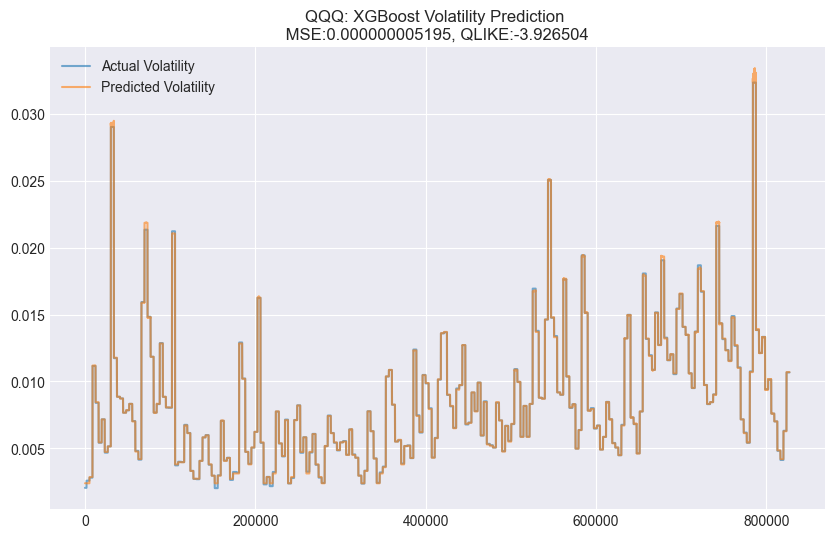

In [26]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"QQQ: XGBoost Volatility Prediction \n MSE:{mse:.12f}, QLIKE:{qlikel:.6f} ")
plt.show()

## Final Version - aggregating data for each time id. 

In [27]:
agg_df = xgb_df.groupby("time_id")["realized_volatility"].mean().reset_index()

In [28]:
X = agg_df.drop(columns=["time_id", "realized_volatility"])  # all features except time_id and target
y = agg_df["realized_volatility"]

In [29]:
agg_df = xgb_df.groupby("time_id").agg({
    "realized_volatility": "mean",
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "spread_variation": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]

In [30]:
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

In [31]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
X_test

,wap,spread_pct,imbalance,depth_ratio,spread_variation,log_return,bid_ask_spread
921,368.479517,0.000036,-0.003142,38.121528,0.000011,7.694779e-08,0.013159
922,368.346940,0.000034,-0.066340,22.290363,0.000010,-1.633192e-08,0.012671
923,368.441315,0.000032,-0.088601,21.127205,0.000008,-8.600406e-08,0.011619
924,364.930544,0.000036,-0.016839,7.014589,0.000012,1.329295e-06,0.013279
925,364.999920,0.000034,-0.123969,5.359140,0.000011,-9.180708e-07,0.012552
...,...,...,...,...,...,...,...
1147,365.130620,0.000034,-0.104536,11.182900,0.000010,2.698801e-07,0.012335
1148,365.204488,0.000035,-0.054094,9.464210,0.000011,-9.630099e-08,0.012689
1149,365.059287,0.000034,-0.044878,14.660589,0.000010,-3.071260e-07,0.012489
1150,364.197480,0.000035,0.004699,8.219428,0.000011,3.576154e-07,0.012573


In [33]:
y_pred = xgb_model.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, y_pred)
qlikel = qlike(y_test.values, y_pred)

print(f"MSE: {mse:.12f}")
print(f"QLIKE: {qlikel:.6f}")

MSE: 0.000014424478
QLIKE: -3.822595


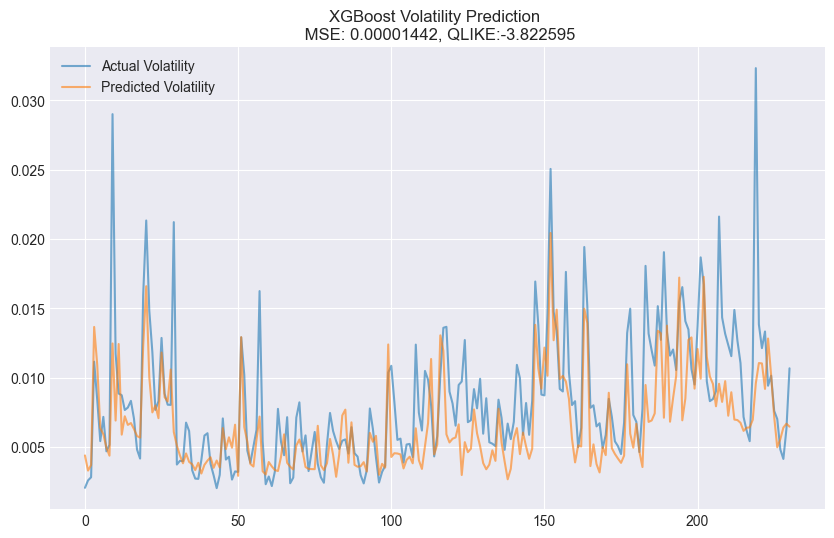

In [35]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Volatility", alpha=0.6)
plt.plot(y_pred, label="Predicted Volatility", alpha=0.6)
plt.legend()
plt.title(f"XGBoost Volatility Prediction \n MSE: {mse:.8f}, QLIKE:{qlikel:.6f}")
plt.show()

# BAS Prediction

C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\3182642794.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_volatility_lead1'] = X_pred
C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\3182642794.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)
C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\3182642794.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

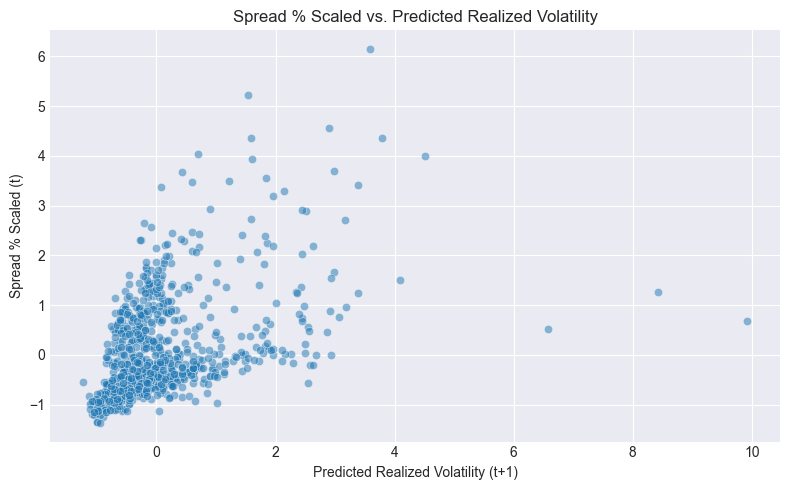


# --- 3. Statistical Assessment ---
# Rainbow test statistic: 5.8887
# P-value: 0.0000
# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).
# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:
# Correlation coefficient: 0.4895
# P-value: 1.17e-56
# The correlation is statistically significant.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import pearsonr # Ensure this is imported at the top

X_pred = xgb_model.predict(X_train)
X_train['predicted_volatility_lead1'] = X_pred
X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)

scaler = StandardScaler()
X_train["realized_volatility"] = y_train
X_train[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])

X_train_analysis = X_train.dropna(subset=['predicted_volatility_lead1', 'spread_pct_scaled']).copy()

if X_train_analysis.empty:
    print("# DataFrame is empty after dropping NaN values. Cannot proceed with analysis.")
else:

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='predicted_volatility_lead1', y='spread_pct_scaled', data=X_train_analysis, alpha=0.5) # Added alpha for better viz if points overlap
    plt.title('Spread % Scaled vs. Predicted Realized Volatility')
    plt.xlabel('Predicted Realized Volatility (t+1)')
    plt.ylabel('Spread % Scaled (t)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\n# --- 3. Statistical Assessment ---")

    X_stat = X_train_analysis[['predicted_volatility_lead1']]
    y_stat = X_train_analysis['spread_pct_scaled']

    X_with_const_stat = sm.add_constant(X_stat)

    try:
        ols_model_stat = sm.OLS(y_stat, X_with_const_stat).fit()
        # Perform Rainbow test
        rainbow_statistic, p_value = linear_rainbow(ols_model_stat)
        print(f"# Rainbow test statistic: {rainbow_statistic:.4f}")
        print(f"# P-value: {p_value:.4f}")

        if p_value < 0.05:
            print("# Interpretation: The Rainbow test suggests evidence of non-linearity (p-value < 0.05).")
        else:
            print("# Interpretation: The Rainbow test shows no evidence against linearity (p-value >= 0.05).")
    except Exception as e:
        print(f"# OLS model fitting or Rainbow test could not be performed: {e}")
        print("# This can happen with insufficient data, perfect multicollinearity, or other data issues.")

    try:
        corr_coef_scipy, p_val_scipy = pearsonr(X_train_analysis['predicted_volatility_lead1'], X_train_analysis['spread_pct_scaled'])
        print(f"# Pearson Correlation between Bid-Ask Spread Percentage and Predicted Realized Volatility:")
        print(f"# Correlation coefficient: {corr_coef_scipy:.4f}")
        print(f"# P-value: {p_val_scipy:.4g}") # Using .4g for scientific notation if p-value is very small
        if p_val_scipy < 0.05:
            print("# The correlation is statistically significant.")
        else:
            print("# The correlation is not statistically significant.")
    except Exception as e:
        print(f"# Pearson correlation could not be computed: {e}")


In [37]:
X_train

,wap,spread_pct,imbalance,depth_ratio,spread_variation,log_return,bid_ask_spread,predicted_volatility_lead1,bid_ask_spread_lead1,realized_volatility,spread_pct_scaled,realized_volatility_scaled
0,310.606478,0.000063,0.043725,9.229372,0.000018,5.210279e-07,0.019655,0.599885,0.018914,0.013922,2.087405,0.597769
1,310.160197,0.000061,-0.072774,12.333972,0.000018,-8.791173e-07,0.018914,-0.006598,0.018577,0.009318,1.863911,-0.106145
2,309.973885,0.000060,-0.004143,11.036411,0.000017,2.584250e-07,0.018577,-0.178572,0.017013,0.007836,1.760724,-0.332820
3,310.464634,0.000055,0.060861,12.734618,0.000017,4.699485e-07,0.017013,-0.193099,0.016275,0.004842,1.260089,-0.790529
4,311.633044,0.000052,-0.048210,7.603253,0.000016,-8.367716e-07,0.016275,-0.055128,0.014755,0.010132,1.009270,0.018232
...,...,...,...,...,...,...,...,...,...,...,...,...
916,367.332820,0.000032,0.121319,9.233880,0.000009,-3.123871e-07,0.011844,-0.972828,0.011114,0.003916,-0.940220,-0.932082
917,367.675897,0.000030,0.024531,11.921467,0.000006,1.079811e-07,0.011114,-1.045269,0.016071,0.003159,-1.136976,-1.047924
918,368.537877,0.000044,-0.025046,18.703873,0.000013,3.158827e-07,0.016071,-0.591728,0.015715,0.006343,0.168445,-0.561057
919,368.348138,0.000043,-0.042226,31.398722,0.000013,-1.835156e-07,0.015715,-0.815087,0.013355,0.004482,0.076236,-0.845668


In [38]:
X_test

,wap,spread_pct,imbalance,depth_ratio,spread_variation,log_return,bid_ask_spread
921,368.479517,0.000036,-0.003142,38.121528,0.000011,7.694779e-08,0.013159
922,368.346940,0.000034,-0.066340,22.290363,0.000010,-1.633192e-08,0.012671
923,368.441315,0.000032,-0.088601,21.127205,0.000008,-8.600406e-08,0.011619
924,364.930544,0.000036,-0.016839,7.014589,0.000012,1.329295e-06,0.013279
925,364.999920,0.000034,-0.123969,5.359140,0.000011,-9.180708e-07,0.012552
...,...,...,...,...,...,...,...
1147,365.130620,0.000034,-0.104536,11.182900,0.000010,2.698801e-07,0.012335
1148,365.204488,0.000035,-0.054094,9.464210,0.000011,-9.630099e-08,0.012689
1149,365.059287,0.000034,-0.044878,14.660589,0.000010,-3.071260e-07,0.012489
1150,364.197480,0.000035,0.004699,8.219428,0.000011,3.576154e-07,0.012573


In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

# Now select features and target
X = agg_df.drop(columns=["time_id", "realized_volatility"])
y = agg_df["realized_volatility"]
cutoff = int(len(agg_df) * 0.8)

X_train = X.iloc[:cutoff]
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:]
y_test = y.iloc[cutoff:]

X_pred = xgb_model.predict(X_train)
X_train['predicted_volatility_lead1'] = X_pred
X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)

X_train = X_train.dropna()

if X_train.empty or len(X_train) < 5: 
    print("Not enough data after aggregation to perform train-test split.")
else:
    feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled', 'wap', 'imbalance',
                'depth_ratio', 'spread_variation', 'log_return', 'bid_ask_spread']

    print("\n# --- Train-Test Split ---")

    # Prepare train
    X_train_ = X_train.copy()
    X_train_['realized_volatility'] = y_train

    # Fit scaler on train only
    scaler = StandardScaler()
    X_train_scaled_cols = scaler.fit_transform(X_train_[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
    X_train_[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_train_scaled_cols

    # Prepare test (use same fitted scaler)
    X_test_pred = xgb_model.predict(X_test)
    X_test['predicted_volatility_lead1'] = X_test_pred
    X_test['bid_ask_spread_lead1'] = X_test['bid_ask_spread'].shift(-1)
    X_test["realized_volatility"] = y_test

    X_test_scaled_cols = scaler.transform(X_test[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
    X_test[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = X_test_scaled_cols

    # Clean up missing rows after shift (always do after all transformations)
    X_test = X_test.dropna().copy()

    # Select only feature columns
    X_train_final = X_train_[feature_cols]
    X_test_final = X_test[feature_cols]

    # Define targets
    y_train_final = X_train_['bid_ask_spread_lead1']
    y_test_final = X_test['bid_ask_spread_lead1']
    
    print(f"Training set shapes: X_train: {X_train_final.shape}, y_train: {y_train_final.shape}")
    print(f"Test set shapes: X_test: {X_test_final.shape}, y_test: {y_test_final.shape}")

    if X_train_final.shape[0] == 0 or X_test_final.shape[0] == 0:
        print("Training or test set is empty after split")
    else:
        print("\n# --- Hyperparameter Tuning ---")
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
        }

        xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
        
        # Using fewer cv folds if dataset is small to avoid errors with too few samples per fold
        cv_folds = min(5, X_train_final.shape[0]) if X_train_final.shape[0] > 1 else 2 # Ensure at least 2 folds if possible
        if X_train_final.shape[0] < 2: # Cannot perform CV with less than 2 samples
             print("Not enough samples in the training set for cross-validation.")
             best_model = xgb_reg # Use default parameters
             best_model.fit(X_train_final, y_train_final)
        else:
            grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                                       scoring='neg_mean_squared_error', cv=cv_folds,
                                       verbose=1, n_jobs=-1) # Use all available cores
            grid_search.fit(X_train_final, y_train_final)
            
            print(f"Best parameters found: {grid_search.best_params_}")
            best_model = grid_search.best_estimator_

        # --- Model Evaluation with the best model ---
        print("\n# --- Evaluation of Best Model ---")
        y_pred_best = best_model.predict(X_test_final)

        mse_best = mean_squared_error(y_test_final, y_pred_best)
        mae_best = mean_absolute_error(y_test_final, y_pred_best)
        rmse_best = np.sqrt(mse_best)
        r2_best = r2_score(y_test_final, y_pred_best)

        print(f"Best Model - Mean Squared Error (MSE): {mse_best:.6f}")
        print(f"Best Model - Mean Absolute Error (MAE): {mae_best:.6f}")
        print(f"Best Model - Root Mean Squared Error (RMSE): {rmse_best:.6f}")
        print(f"Best Model - R-squared (R²): {r2_best:.4f}")

        model_filename = 'bid_ask_spread_model.pkl'
        joblib.dump(best_model, model_filename)
        print(f"Best model saved as {model_filename}")

        print("\n# --- Comparison of Actual vs. Predicted Bid-Ask Spread (Test Set) - Best Model ---")
        test_indices_best = y_test_final.index 
        test_time_ids_best = agg_df.loc[test_indices_best, 'time_id']

        comparison_df_best = pd.DataFrame({
            'time_id': test_time_ids_best.values,
            'actual_bid_ask_spread': y_test_final.values,
            'predicted_bid_ask_spread': y_pred_best
        })
        print("Comparison DataFrame (first 5 rows):")
        print(comparison_df_best.head())
        print(f"\nComparison DataFrame shape: {comparison_df_best.shape}")



# --- Train-Test Split ---
Training set shapes: X_train: (920, 9), y_train: (920,)
Test set shapes: X_test: (230, 9), y_test: (230,)

# --- Hyperparameter Tuning ---
Fitting 5 folds for each of 768 candidates, totalling 3840 fits


C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\858150639.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['predicted_volatility_lead1'] = X_pred
C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\858150639.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['bid_ask_spread_lead1'] = X_train['bid_ask_spread'].shift(-1)
C:\Users\dungh\AppData\Local\Temp\ipykernel_15608\858150639.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}

# --- Evaluation of Best Model ---
Best Model - Mean Squared Error (MSE): 0.000002
Best Model - Mean Absolute Error (MAE): 0.000899
Best Model - Root Mean Squared Error (RMSE): 0.001342
Best Model - R-squared (R²): 0.3541
Best model saved as bid_ask_spread_model.pkl

# --- Comparison of Actual vs. Predicted Bid-Ask Spread (Test Set) - Best Model ---
Comparison DataFrame (first 5 rows):
   time_id  actual_bid_ask_spread  predicted_bid_ask_spread
0      963               0.012671                  0.013038
1      964               0.011619                  0.012740
2      965               0.013279                  0.012097
3      966               0.012552                  0.013409
4      967               0.011924                  0.012566

Comparison DataFrame shape: (230, 3)


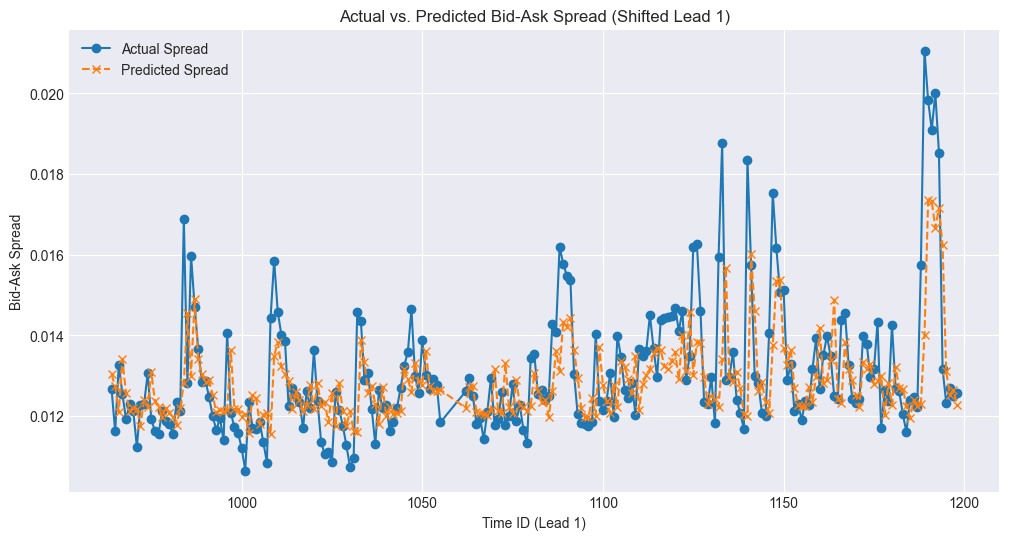

In [40]:
comparison_df_best['time_id_lead1'] = comparison_df_best['time_id'].shift(-1)
plt.figure(figsize=(12, 6))
plt.plot(comparison_df_best['time_id_lead1'], comparison_df_best['actual_bid_ask_spread'], label='Actual Spread', marker='o', linestyle='-')
plt.plot(comparison_df_best['time_id_lead1'], comparison_df_best['predicted_bid_ask_spread'], label='Predicted Spread', marker='x', linestyle='--')
plt.xlabel('Time ID (Lead 1)')
plt.ylabel('Bid-Ask Spread')
plt.title('Actual vs. Predicted Bid-Ask Spread (Shifted Lead 1)')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
comparison_df_best.head()


,time_id,actual_bid_ask_spread,predicted_bid_ask_spread,time_id_lead1
0,963,0.012671,0.013038,964.0
1,964,0.011619,0.012740,965.0
2,965,0.013279,0.012097,966.0
3,966,0.012552,0.013409,967.0
4,967,0.011924,0.012566,968.0


# BAS Model but not using predicted values for training set

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

print("# --- Data Preparation ---")

print(f"df shape after initial preparation: {xgb_df.shape}")

scaler = StandardScaler()
xgb_df[['spread_pct_scaled', 'realized_volatility_scaled']] = scaler.fit_transform(xgb_df[['spread_pct', 'realized_volatility']])
xgb_df['realized_volatility_lead1'] = xgb_df['realized_volatility_scaled'].shift(-1)
xgb_df_analysis = xgb_df.dropna(subset=['realized_volatility_lead1', 'spread_pct_scaled']).copy()

# Aggregate at time_id level
agg_df = xgb_df.groupby('time_id').agg({
    'realized_volatility_lead1': 'mean',
    'realized_volatility_scaled': 'mean',
    'spread_pct': 'mean',
    'wap': 'mean',
    'imbalance': 'mean',
    'depth_ratio': 'mean',
    'spread_variation': 'mean',
    'log_return': 'mean',
    'bid_ask_spread': 'mean' 
}).reset_index()
agg_df['bid_ask_spread_lead1'] = agg_df['bid_ask_spread'].shift(-1)
agg_df = agg_df.dropna().reset_index(drop=True)
print(f"agg_df shape after aggregation and dropna: {agg_df.shape}")

if agg_df.empty or len(agg_df) < 5: 
    print("Not enough data after aggregation to perform train-test split.")
else:
    feature_cols = ['realized_volatility_lead1', 'spread_pct', 'wap', 'imbalance',
                    'depth_ratio', 'spread_variation', 'log_return', 'realized_volatility_scaled']
    X = agg_df[feature_cols]
    y = agg_df['bid_ask_spread']
    print(X.columns.tolist())

    print("\n# --- Train-Test Split ---")
    # Time series style split without shuffling
    split_idx = int(len(X) * 0.8)
    X_train = X.iloc[:split_idx].reset_index(drop=True)
    X_test = X.iloc[split_idx:].reset_index(drop=True)
    y_train = y.iloc[:split_idx].reset_index(drop=True)
    y_test = y.iloc[split_idx:].reset_index(drop=True)

    X_test.drop(columns=['realized_volatility_lead1'], inplace=True)
    X_test['realized_volatility_lead1'] = y_pred
    X_test = X_test[X_train.columns]

    # Fit scaler only on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  

    print("\n# --- Hyperparameter Tuning ---")
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
    
    cv_folds = min(5, X_train_scaled.shape[0]) if X_train_scaled.shape[0] > 1 else 2
    if X_train_scaled.shape[0] < 2:
        print("Not enough samples in the training set for cross-validation.")
        best_model = xgb_reg
        best_model.fit(X_train_scaled, y_train)
    else:
        grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid,
                                   scoring='neg_mean_squared_error', cv=cv_folds,
                                   verbose=1, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        print(f"Best parameters found: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_

    # --- Evaluation ---
    print("\n# --- Evaluation of Best Model ---")
    y_pred_best = best_model.predict(X_test_scaled)

    mse_best = mean_squared_error(y_test, y_pred_best)
    mae_best = mean_absolute_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)

    print(f"Best Model - Mean Squared Error (MSE): {mse_best:.6f}")
    print(f"Best Model - Mean Absolute Error (MAE): {mae_best:.6f}")
    print(f"Best Model - Root Mean Squared Error (RMSE): {rmse_best:.6f}")
    print(f"Best Model - R-squared (R²): {r2_best:.4f}")
    
    # --- Comparison DataFrame ---
    comparison_df_best = pd.DataFrame({
        'time_id': agg_df.loc[split_idx:, 'time_id'].values,
        'actual_bid_ask_spread': y_test.values,
        'predicted_bid_ask_spread': y_pred_best
    })
    print("Comparison DataFrame (first 5 rows):")
    print(comparison_df_best.head())
    print(f"\nComparison DataFrame shape: {comparison_df_best.shape}")


# --- Data Preparation ---
df shape after initial preparation: (4135632, 37)
agg_df shape after aggregation and dropna: (1151, 11)
['realized_volatility_lead1', 'spread_pct', 'wap', 'imbalance', 'depth_ratio', 'spread_variation', 'log_return', 'realized_volatility_scaled']

# --- Train-Test Split ---

# --- Hyperparameter Tuning ---
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}

# --- Evaluation of Best Model ---
Best Model - Mean Squared Error (MSE): 0.000000
Best Model - Mean Absolute Error (MAE): 0.000275
Best Model - Root Mean Squared Error (RMSE): 0.000426
Best Model - R-squared (R²): 0.9348
Best model saved as bid_ask_spread_model_noleak.pkl
Comparison DataFrame (first 5 rows):
   time_id  actual_bid_ask_spread  predicted_bid_ask_spread
0      962               0.013355                  0.012592
1      963               0.013159          

In [58]:
comparison_df_best

,time_id,actual_bid_ask_spread,predicted_bid_ask_spread
0,962,0.013355,0.012592
1,963,0.013159,0.012655
2,964,0.012671,0.012264
3,965,0.011619,0.011516
4,966,0.013279,0.013280
...,...,...,...
226,1194,0.013175,0.013280
227,1195,0.012335,0.012193
228,1196,0.012689,0.012867
229,1197,0.012489,0.012193


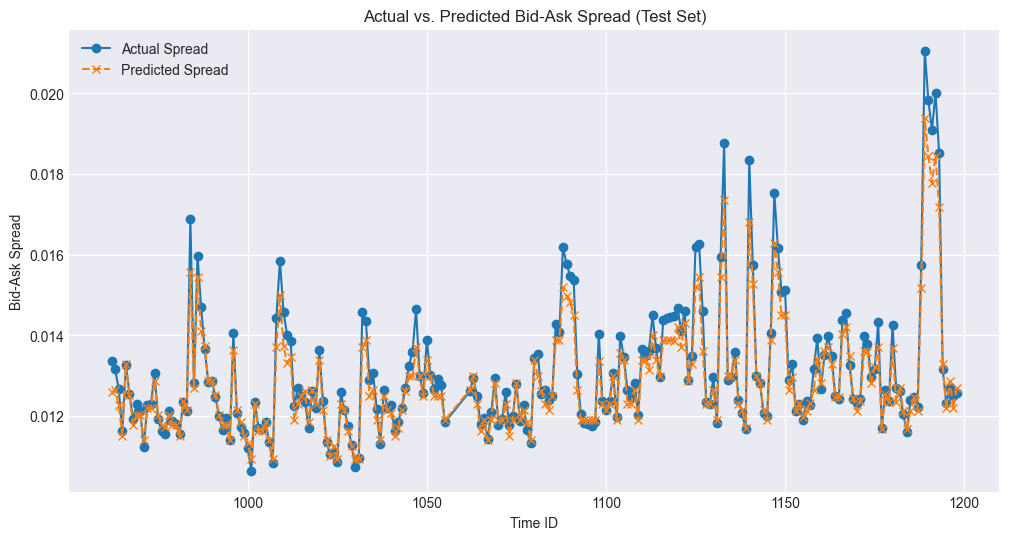

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df_best['time_id'], comparison_df_best['actual_bid_ask_spread'], label='Actual Spread', marker='o', linestyle='-')
plt.plot(comparison_df_best['time_id'], comparison_df_best['predicted_bid_ask_spread'], label='Predicted Spread', marker='x', linestyle='--')
plt.xlabel('Time ID')
plt.ylabel('Bid-Ask Spread')
plt.title('Actual vs. Predicted Bid-Ask Spread (Test Set)')
plt.legend()
plt.grid(True)
plt.show()